In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


Import Skin Cancer Data and Libraries
Context: Utilize essential libraries and import skin cancer data. Load the data using keras.preprocessing, create a dataset, and visualize it. Build, compile, and train a CNN-based model. Visualize the training results. Assess the distribution of augmented data following the addition of new images to the original training data.

Problem Statement: Develop a CNN model capable of accurately detecting melanoma, a potentially deadly form of skin cancer accounting for 75% of skin cancer deaths. Such a solution could significantly reduce the manual effort required for diagnosis by evaluating images and alerting dermatologists to the presence of melanoma.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining the path for train and test images
mel_data_train = pathlib.Path("/content/drive/MyDrive/Upgrad/Cancer/Train")
mel_data_test = pathlib.Path('/content/drive/MyDrive/Upgrad/Cancer/Test')

In [ ]:
train_img_cnt = len(list(mel_data_train.glob('*/*.jpg')))
print(train_img_cnt)
test_img_cnt = len(list(mel_data_test.glob('*/*.jpg')))
print(test_img_cnt)

2239
118


In [ ]:
batch_size = 32
img_h = 180
img_w = 180

In [ ]:
mel_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    mel_data_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_h,img_w),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
mel_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    mel_data_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_h,img_w),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
#Listing out types of skin cancer data
type_names = mel_train_data.class_names
print(type_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Visualising the data**


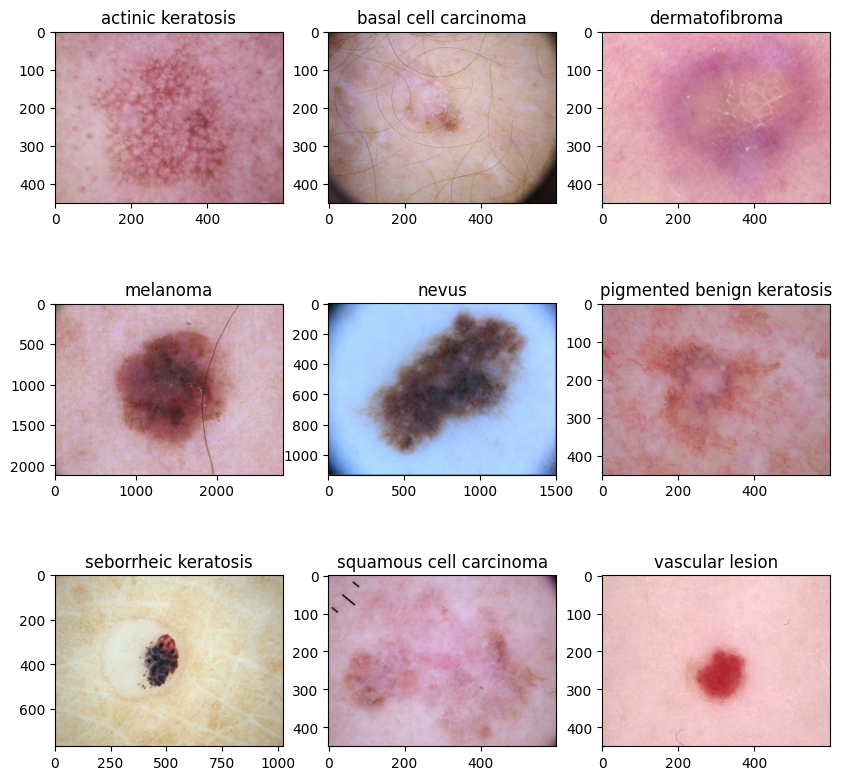

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(mel_data_train.glob(type_names[i]+'/*.jpg'))[1]))
  plt.title(type_names[i])
  plt.imshow(image)

The tensor image_batch represents a batch containing 32 images, each with dimensions 180x180x3 (where the last dimension represents the RGB color channels). The tensor label_batch contains corresponding labels for the 32 images.







Dataset.cache() stores the images in memory after loading them from disk during the initial epoch.

Dataset.prefetch() allows for concurrent data preprocessing and model execution during training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
mel_train_data = mel_train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
mel_val_data = mel_val_data.cache().prefetch(buffer_size=AUTOTUNE)

## **Creating the model**

Build a CNN model capable of accurately classifying the 9 classes within the dataset. Normalize pixel values between 0 and 1 using layers.experimental.preprocessing.Rescaling. It's recommended to standardize values within this range, as RGB channel values typically range from 0 to 255, which isn't optimal for neural networks.

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_h, img_w,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [ ]:
##compiling to optimise the training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#reviewing the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

In [ ]:
#Training the Model
epochs = 30
hist = model.fit(
  mel_train_data,
  validation_data=mel_val_data,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 167s 628ms/step - loss: 2.0588 - accuracy: 0.1953 - val_loss: 2.0318 - val_accuracy: 0.2081
Epoch 2/30
56/56 [==============================] - 5s 88ms/step - loss: 1.9673 - accuracy: 0.2439 - val_loss: 1.8694 - val_accuracy: 0.2975
Epoch 3/30
56/56 [==============================] - 5s 88ms/step - loss: 1.8560 - accuracy: 0.3058 - val_loss: 1.8099 - val_accuracy: 0.2998
Epoch 4/30
56/56 [==============================] - 5s 88ms/step - loss: 1.7457 - accuracy: 0.3605 - val_loss: 1.7279 - val_accuracy: 0.3893
Epoch 5/30
56/56 [==============================] - 5s 89ms/step - loss: 1.7081 - accuracy: 0.3711 - val_loss: 1.6048 - val_accuracy: 0.3960
Epoch 6/30
56/56 [==============================] - 5s 89ms/step - loss: 1.5938 - accuracy: 0.4163 - val_loss: 1.6383 - val_accuracy: 0.4049
Epoch 7/30
56/56 [==============================] - 5s 89ms/step - loss: 1.5605 - accuracy: 0.4325 - val_loss: 1.5284 - val_accuracy: 0.4362
Epoch 8/30
56/56 [===

**Visualizing training results**

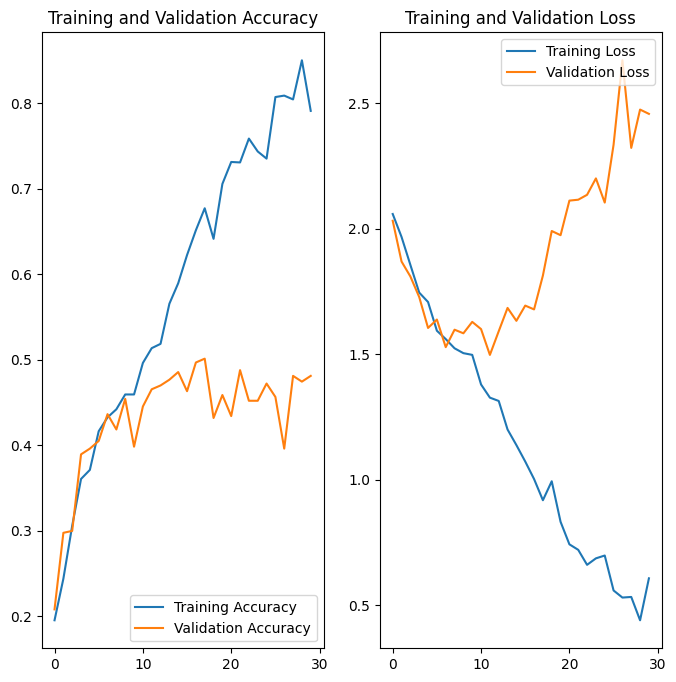

In [ ]:
accuracy_model = hist.history['accuracy']
val_accuracy_model = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy_model, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy_model, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Initial observations on the base model indicate potential overfitting, as evidenced by diverging loss functions between training and testing data around the 10-11th epoch.

The accuracy currently stands at approximately 75-80%, suggesting the presence of sufficient features to memorize patterns.

However, it's premature to conclusively determine the presence of overfitting or underfitting at this stage.

In [ ]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_h,img_w,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

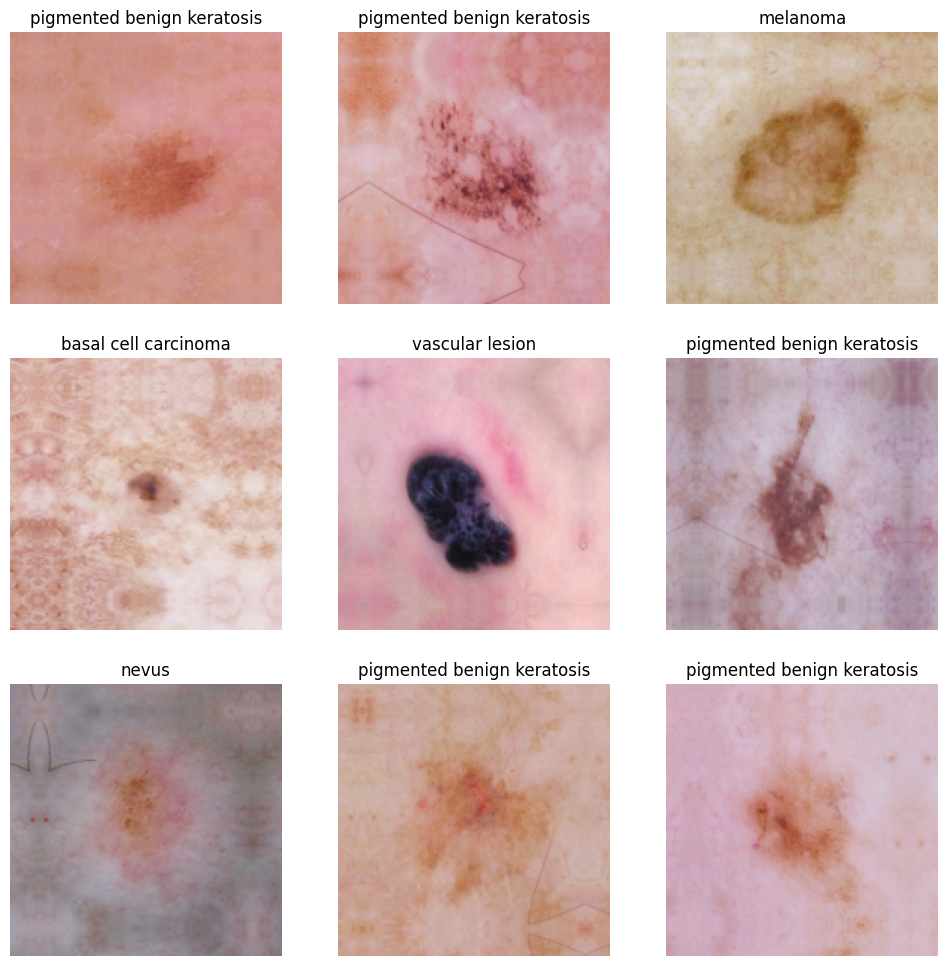

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in mel_train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(type_names[labels[i]])
        plt.axis("off")

In [ ]:
#Creating the model

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_h, img_w,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



In [ ]:
#Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Training the model
epochs=30
hist = model.fit(
  mel_train_data,
  validation_data=mel_val_data,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 10s 116ms/step - loss: 2.0366 - accuracy: 0.2048 - val_loss: 2.0069 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 6s 105ms/step - loss: 1.9035 - accuracy: 0.2695 - val_loss: 1.8221 - val_accuracy: 0.3423
Epoch 3/30
56/56 [==============================] - 6s 103ms/step - loss: 1.9106 - accuracy: 0.2690 - val_loss: 1.8247 - val_accuracy: 0.3065
Epoch 4/30
56/56 [==============================] - 6s 104ms/step - loss: 1.7860 - accuracy: 0.3337 - val_loss: 1.7101 - val_accuracy: 0.3579
Epoch 5/30
56/56 [==============================] - 6s 103ms/step - loss: 1.7597 - accuracy: 0.3650 - val_loss: 1.7556 - val_accuracy: 0.3893
Epoch 6/30
56/56 [==============================] - 6s 103ms/step - loss: 1.6834 - accuracy: 0.3962 - val_loss: 1.8819 - val_accuracy: 0.3132
Epoch 7/30
56/56 [==============================] - 6s 102ms/step - loss: 1.6763 - accuracy: 0.3917 - val_loss: 1.6952 - val_accuracy: 0.4116
Epoch

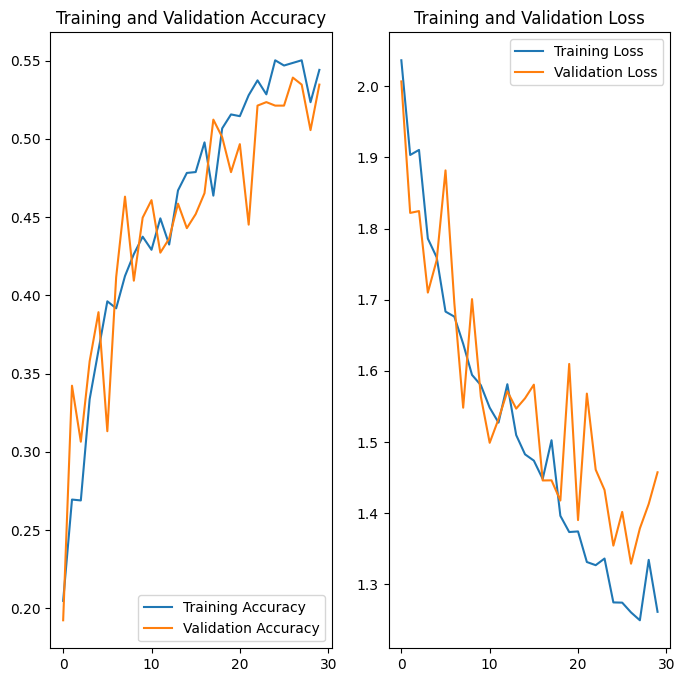

In [ ]:
#Visualising the history
accuracy_model = hist.history['accuracy']
val_accuracy_model = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy_model, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy_model, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observations from the second model reveal that while there hasn't been a notable improvement in accuracy, the overfitting issue appears to have been addressed thanks to data augmentation techniques.

Considering the lack of significant accuracy gains, it's premature to draw definitive conclusions.

Task: Determine the distribution of classes within the training dataset.

Context: Real-world datasets often exhibit class imbalance, where certain classes may have significantly more samples compared to others. Class imbalance can adversely impact model performance, making it crucial to examine the distribution of classes within the data as a sanity check.

In [ ]:
path=[]
lesion=[]
for i in type_names:

    for j in mel_data_train.glob(i+'/*.jpg'):
        path.append(str(j))
        lesion.append(i)
dataframe_dict_original = dict(zip(path, lesion))
og_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
og_df

,Path,Label
0,/content/drive/MyDrive/Upgrad/Cancer/Train/act...,actinic keratosis
1,/content/drive/MyDrive/Upgrad/Cancer/Train/act...,actinic keratosis
2,/content/drive/MyDrive/Upgrad/Cancer/Train/act...,actinic keratosis
3,/content/drive/MyDrive/Upgrad/Cancer/Train/act...,actinic keratosis
4,/content/drive/MyDrive/Upgrad/Cancer/Train/act...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Upgrad/Cancer/Train/vas...,vascular lesion
2235,/content/drive/MyDrive/Upgrad/Cancer/Train/vas...,vascular lesion
2236,/content/drive/MyDrive/Upgrad/Cancer/Train/vas...,vascular lesion
2237,/content/drive/MyDrive/Upgrad/Cancer/Train/vas...,vascular lesion


In [ ]:
dataframe_dict_original = dict(zip(path, lesion))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
og_df

,Path,Label
0,/content/drive/MyDrive/Upgrad/Cancer/Train/act...,actinic keratosis
1,/content/drive/MyDrive/Upgrad/Cancer/Train/act...,actinic keratosis
2,/content/drive/MyDrive/Upgrad/Cancer/Train/act...,actinic keratosis
3,/content/drive/MyDrive/Upgrad/Cancer/Train/act...,actinic keratosis
4,/content/drive/MyDrive/Upgrad/Cancer/Train/act...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Upgrad/Cancer/Train/vas...,vascular lesion
2235,/content/drive/MyDrive/Upgrad/Cancer/Train/vas...,vascular lesion
2236,/content/drive/MyDrive/Upgrad/Cancer/Train/vas...,vascular lesion
2237,/content/drive/MyDrive/Upgrad/Cancer/Train/vas...,vascular lesion


<BarContainer object of 9 artists>

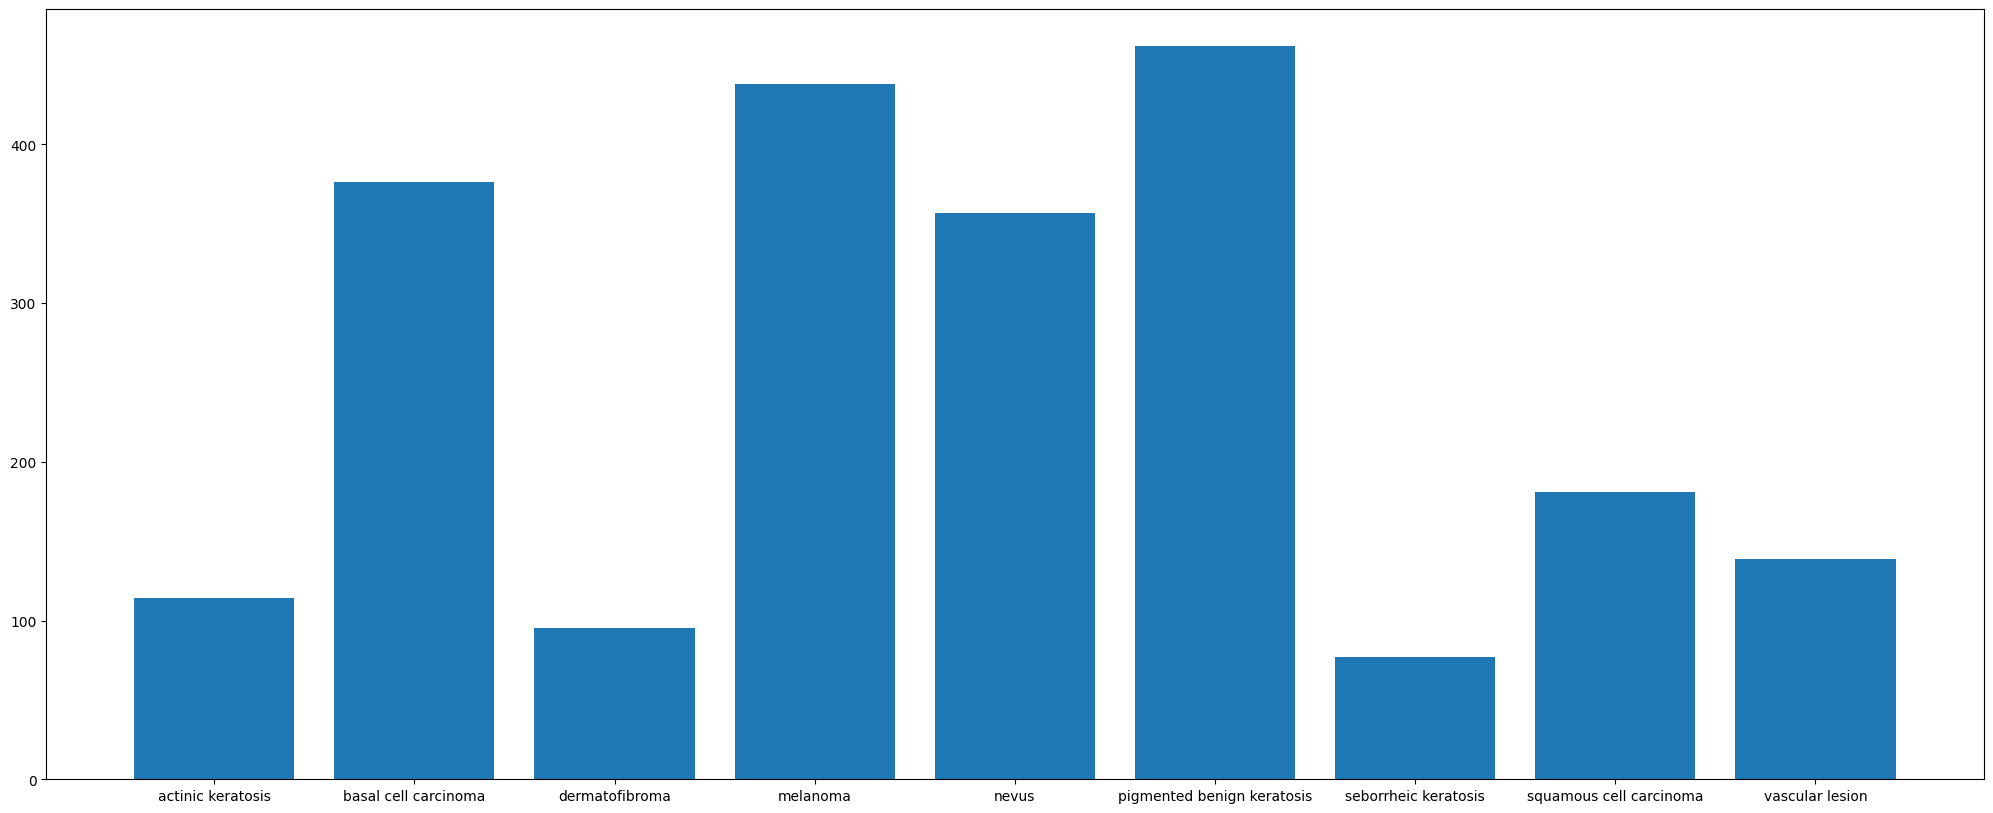

In [ ]:
count=[]
for i in type_names:
    count.append(len(list(mel_data_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(type_names,count)

The class with the lowest number of samples is squamous cell carcinoma.

Actinic keratosis and dermatofibroma exhibit a balanced distribution in terms of the number of samples. Conversely, melanoma and pigmented benign keratosis also demonstrate a balanced proportion of samples.


Addressing Class Imbalance
Context: To mitigate class imbalance, leverage the Augmentor Python package (https://augmentor.readthedocs.io/en/master/) to augment data across all classes, ensuring none of them are underrepresented.


In [ ]:
!pip install Augmentor


In [ ]:
import Augmentor
for i in type_names:
    p = Augmentor.Pipeline("/content/drive/MyDrive/Upgrad/Cancer/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D0E88073850>: 100%|██████████| 500/500 [00:09<00:00, 50.71 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0E781A9B40>: 100%|██████████| 500/500 [00:09<00:00, 50.32 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Cancer/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D0E88169BD0>: 100%|██████████| 500/500 [00:09<00:00, 50.63 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0DE4241FC0>: 100%|██████████| 500/500 [00:12<00:00, 39.33 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Cancer/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7D0DC4708B20>: 100%|██████████| 500/500 [00:09<00:00, 53.92 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0DE4107460>: 100%|██████████| 500/500 [00:10<00:00, 47.17 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=724x542 at 0x7D0E88168190>: 100%|██████████| 500/500 [00:10<00:00, 47.35 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Cancer/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D0DE4104340>: 100%|██████████| 500/500 [00:10<00:00, 48.44 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Upgrad/Cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0F20F94B80>: 100%|██████████| 500/500 [00:10<00:00, 49.32 Samples/s]


Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
mel_data_train_new = pathlib.Path("/content/drive/MyDrive/Upgrad/Cancer/Train/output")
train_img_cnt_new = len(list(mel_data_train_new.glob('*/*.jpg')))
print(train_img_cnt_new)

4500


In [ ]:
new_df['Label'].value_counts()


pigmented benign keratosis    1366
melanoma                      1315
basal cell carcinoma          1136
nevus                         1064
squamous cell carcinoma        551
vascular lesion                435
actinic keratosis              356
dermatofibroma                 288
seborrheic keratosis           228
Name: Label, dtype: int64

In [ ]:
batch_size = 32
img_h = 180
img_w = 180

In [ ]:
import pathlib
mel_data_train_new=pathlib.Path("/content/drive/MyDrive/Upgrad/Cancer/Train")

In [ ]:
mel_data_train_new

PosixPath('/content/drive/MyDrive/Upgrad/Cancer/Train')

In [ ]:
train_img_cnt_new = len(list(mel_data_train_new.glob('*/*.jpg')))
print(train_img_cnt_new)

2239


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


mel_data_train_new=pathlib.Path("/content/drive/MyDrive/Upgrad/Cancer/Train/output")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  mel_data_train_new,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_h, img_w),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [ ]:
mel_val_data = tf.keras.preprocessing.image_dataset_from_directory(
  mel_data_train_new,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_h, img_w),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_h, img_w,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
epochs =50
hist = model.fit(
  mel_train_data,
  validation_data=mel_val_data,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 10s 154ms/step - loss: 2.0571 - accuracy: 0.2015 - val_loss: 1.9247 - val_accuracy: 0.3189
Epoch 2/50
56/56 [==============================] - 8s 145ms/step - loss: 1.8905 - accuracy: 0.2930 - val_loss: 1.8309 - val_accuracy: 0.3244
Epoch 3/50
56/56 [==============================] - 8s 144ms/step - loss: 1.8264 - accuracy: 0.3292 - val_loss: 1.7357 - val_accuracy: 0.3489
Epoch 4/50
56/56 [==============================] - 8s 143ms/step - loss: 1.7236 - accuracy: 0.3689 - val_loss: 1.7708 - val_accuracy: 0.3844
Epoch 5/50
56/56 [==============================] - 8s 144ms/step - loss: 1.6256 - accuracy: 0.4235 - val_loss: 1.5511 - val_accuracy: 0.4322
Epoch 6/50
56/56 [==============================] - 8s 143ms/step - loss: 1.6456 - accuracy: 0.4258 - val_loss: 1.7439 - val_accuracy: 0.3856
Epoch 7/50
56/56 [==============================] - 8s 143ms/step - loss: 1.5782 - accuracy: 0.4342 - val_loss: 1.5226 - val_accuracy: 0.4544
Epoch 8/50
56/56

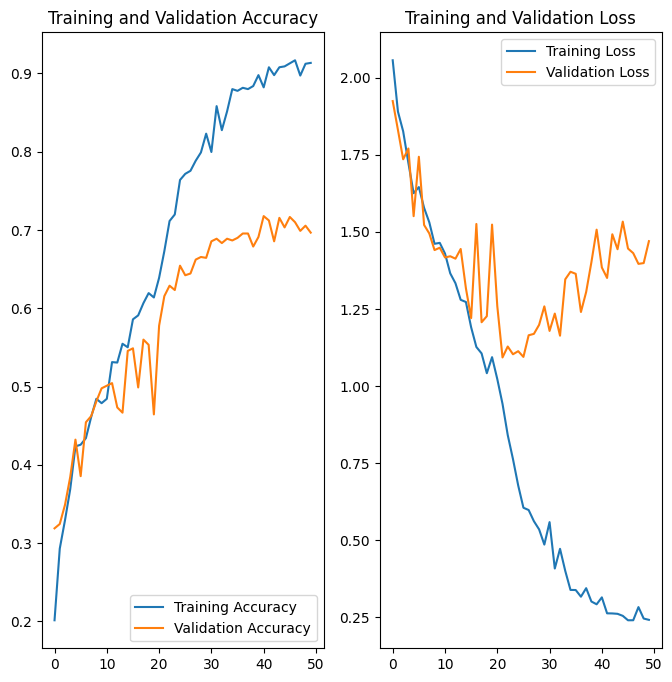

In [ ]:
accuracy_model = hist.history['accuracy']
val_accuracy_model = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy_model, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy_model, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


The training accuracy has improved with the integration of the Augmentor library.

However, the model is still exhibiting signs of overfitting.

To address overfitting, consider adding more layers, neurons, or implementing dropout layers.

Further improvements to the model can be achieved by fine-tuning the hyperparameters.